In [1]:
import os
import editdistance

import random
import ujson as json
from rlagents import QLAgent, benchmark, make_df
import seaborn as sns
import pandas as pd
from tqdm import tqdm_notebook, tqdm, trange
from functools import reduce
from sklearn.metrics import f1_score

import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

%matplotlib inline

## TuringLearner
Can a Reinforcement Agent learn to perform right shift using a Turing Machine?

Turing machines represent a powerful class of computing machines. The Human input to those machines is that part of the machine which contains it's 'programming'. Namely the part which says what action to take.

The premise is that can such an agent learn to perform tasks based on some metric which is task agnostinc. Here we experiment with the metric being fraction of the tape which was an exact mamtch.

In [2]:
from rlagents import __version__
__version__

(0, 0, 25)

## Turing Learner World

In [17]:
class TL:
    def __init__(self, iogen, actions):
        self.iogen = iogen
        self.actions = actions
        self.reset()
    
    def reset(self):
        self.inp, self.expected = self.iogen()
        self.out = list(self.inp)
        self.rlimit = len(self.inp) - 1
        self.head = 0
        self.cache = self.inp[0]
        self.comm = 0
        self.done = False
        return self.__obs()
    
    def __obs(self):
        obs = [self.inp[self.head], self.out[self.head],
               self.cache, self.comm]
        return obs
    
    def step(self, actions):
        if self.done:
            raise Exception('Running done environment {}'.format(self.history) )
        act, comm = actions  # Env action and communication action
        rew = -1
        self.done = (act == 'STOP')
        if act == '>':
            self.head = min(self.rlimit, self.head+1)
        elif act == '<':
            self.head = max(0, self.head - 1)
        elif act == 'read':
            self.cache = self.inp[self.head]
        elif act[:5] == 'write':
            self.out[self.head] = act[5:]
        if self.done:
            laddoo = sum(i==j for i, j in zip(self.expected, self.out))/len(self.expected)
            assert 0 <= laddoo <= 1
            rew += laddoo
        obs = self.__obs() # Get the obs
        self.comm = comm # Set commm for next iteration
        return obs, rew, self.done, None
    
    def copy(self):
        t = TL(self.iogen, self.actions)
        return t

In [33]:
 def check_fn(fn, letters, n_comm=2, eps=50000, trials=100):
    actions = [(a, i)
               for i in range(n_comm)
               for l in letters
               for a in ['<', '>', 'write'+l]]
    actions += [('STOP', 0)]
    actions = list(set(actions))
    
    wo = [TL(fn, actions)]
    ag = [QLAgent(actions)]
    
    print('{:,} actions'.format(len(actions)))
    print('Runing {}'.format(fn.__name__))
    ! rm -rf DataDir/
    paths = benchmark(ag, wo, eps, None, trials)
    df = make_df(paths)
    return df

In [34]:
def evaluate(fn, letters, n_comm=2, episodes=20*1000, measure=None):
    if measure is None:
        measure = lambda a, b: sum(i==j for i, j in zip(a, b))/len(a)
        
    actions = [(a, i)
               for i in range(n_comm)
               for l in letters
               for a in ['<', '>', 'write'+l]]
    actions += [('STOP', 0)]
    actions = list(set(actions))
    
    env = TL(fn, actions)
    ag = QLAgent(actions)
    # ---------------
    data = []
    ag.reset()
    for ep in range(episodes):
        last_episode = (ep+1) == episodes
        obs = env.reset()
        for step in range(int(1e20)):
            act = ag.get_action(obs)
            if last_episode:
                print(''.join(env.out), obs, act)
            obs, rew, done, _ = env.step(act)
            ag.observe_reward(rew)
            if done:
                break
        data.append(measure(env.expected, env.out))
    return data

In [35]:
def paint(df, fn, exp=None, window=100):
    values = [(e, r) for e, r in dict(df.groupby('ep').rew.mean()).items()]
    values.sort(key=lambda x: x[0])
    r = [i[1] for i in values]
    r = pd.Series(r).rolling(window).mean()
    plt.plot(r.index, r.values, label=fn.__name__)
    
    if exp is not None:
        plt.plot(v[:, 0],[exp for _ in v[:, 1]], label='Exp = {}'.format(exp))
    
    plt.xlabel('Episodes')
    plt.ylabel('Mean Total Reward over {:,} trials'.format(df.trial.max()+1))
    plt.legend()
    plt.title('Reward received by Agent. Smoothed ({} window)'.format(window))

## Position Tagging

Here we try to teach it a function which depends only on position and not on the actual text.

In [36]:
def periodic_pos():
    letters = 'abcdefghijklmnopqrtuvwxyz'
    text = [random.choice(letters) for _ in range(10)]
    labels = ['+' if (i%6==0) else '-' for i, letter in enumerate(text)]
    return text, labels

In [37]:
a, b = periodic_pos()
print(''.join(a))
print(''.join(b))

bfiqqwtfcj
+-----+---


In [39]:
df = check_fn(periodic_pos, '+-')

9 actions
Runing periodic_pos
DataDir does not exist. Creating...
Building Dispatch list...
Running experiments...








  0%|          | 0/100 [00:00<?, ?it/s]





 48%|████▊     | 48/100 [01:40<01:54,  2.20s/it]

Stopping Experiments...
48 files
Reading files...




  0%|                                                    | 0/48 [00:00<?, ?it/s]




 96%|█████████████████████████████████████████▏ | 46/48 [00:02<00:00, 23.34it/s]
                                                                                

Painting...


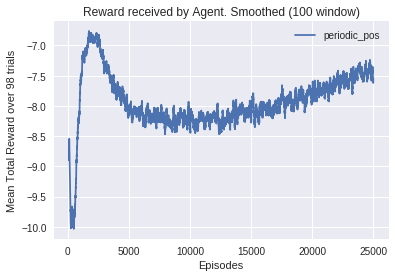

In [40]:
paint(df, periodic_pos)

In [42]:
_ = evaluate(periodic_pos, letters='+-', episodes=20000)

ebyhblalrz ['e', 'e', 'e', 0] ('>', 1)
ebyhblalrz ['b', 'b', 'e', 0] ('write+', 0)
e+yhblalrz ['b', '+', 'e', 1] ('>', 1)
e+yhblalrz ['y', 'y', 'e', 0] ('>', 1)
e+yhblalrz ['h', 'h', 'e', 1] ('write-', 1)
e+y-blalrz ['h', '-', 'e', 1] ('>', 1)
e+y-blalrz ['b', 'b', 'e', 1] ('<', 0)
e+y-blalrz ['h', '-', 'e', 1] ('>', 0)
e+y-blalrz ['b', 'b', 'e', 0] ('write+', 0)
e+y-+lalrz ['b', '+', 'e', 0] ('>', 0)
e+y-+lalrz ['l', 'l', 'e', 0] ('write-', 0)
e+y-+-alrz ['l', '-', 'e', 0] ('>', 0)
e+y-+-alrz ['a', 'a', 'e', 0] ('write+', 0)
e+y-+-+lrz ['a', '+', 'e', 0] ('write+', 1)
e+y-+-+lrz ['a', '+', 'e', 0] ('write+', 0)
e+y-+-+lrz ['a', '+', 'e', 1] ('write+', 1)
e+y-+-+lrz ['a', '+', 'e', 0] ('<', 1)
e+y-+-+lrz ['l', '-', 'e', 1] ('write-', 1)
e+y-+-+lrz ['l', '-', 'e', 1] ('write-', 0)
e+y-+-+lrz ['l', '-', 'e', 1] ('write+', 1)
e+y-+++lrz ['l', '+', 'e', 0] ('>', 0)
e+y-+++lrz ['a', '+', 'e', 1] ('write+', 0)
e+y-+++lrz ['a', '+', 'e', 0] ('>', 1)
e+y-+++lrz ['l', 'l', 'e', 0] ('write+', 1)

## Index and text

a task which depends on both index and task

In [46]:
def postext():
    letters = 'abcdefghijklmnopqrtuvwxyz'
    text = [random.choice(letters) for _ in range(50)]
    labels = ['+' if ((i%5==0 or i%7==0) and letter in 'abc') else '-' for i, letter in enumerate(text)]
    return text, labels

In [47]:
a, b = postext()
print(''.join(a))
print(''.join(b))

wkuvimpucqbhpeklknudwxdygwkkzzlptcqoacgyjkjluprdcl
----------+---------------------------------------


In [48]:
df = check_fn(postext, '+-')

9 actions
Runing postext
DataDir does not exist. Creating...
Building Dispatch list...
Running experiments...







 12%|█▏        | 12/100 [00:41<04:42,  3.21s/it]

Stopping Experiments...
12 files
Reading files...






  0%|                                                    | 0/12 [00:00<?, ?it/s]

 75%|█████████████████████████████████           | 9/12 [00:00<00:00, 12.11it/s]
                                                                                

Painting...


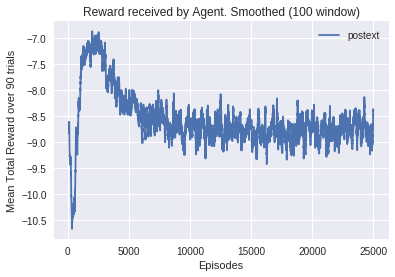

In [49]:
paint(df, postext)


## A more rigorous battery of tasks

We see that these tasks converge to their Edit distances. At this time we are confident enough to try and approach real tasks for this method.

In [ ]:
def sorting():
    letters = 'abcdefghijklmnopqrtuvwxyz'
    text = [random.choice(letters) for _ in range(100)]
    labels = list(sorted(text))
    return text, labels

In [ ]:
letters = 'abcdefghijklmnopqrtuvwxyz'
df = check_fn(sorting, letters, eps=1500)

In [ ]:
paint(df, sorting)

## Learning parameterized functions

We attempt to make it learn a parameterized copy function. A number **M** is given and the next **N** inputs have to be copied **M** number of times. We need the learner to learn the following things.

- what to copy
- how to repeat it
- when to stop repeating it

In [ ]:
def nestedcopy():
    letters = 'bcdefghijklmnopqrtuvwxyz'
    pad_char = 'a'
    letters += pad_char
    lim = 100
    
    text = [random.choice(letters) for _ in range(random.choice(range(1, 11)))]
    rep = random.choice(range(10))
    
    inp = [str(rep)] + text
    label = text*rep
    
    inp, label = inp + [pad_char]*(lim - len(inp)), label + [pad_char]*(lim - len(label))
    return inp[:lim], label[:lim]

In [ ]:
a, b = nestedcopy()
print(''.join(a), len(a))
print(''.join(b), len(b))

In [ ]:
letters = 'abcdefghijklmnopqrtuvwxyz'
df = check_fn(nestedcopy, letters, eps=1500, trials=200)

In [ ]:
paint(df, nestedcopy)

## Addition

We try to teach it addition as an additional example.

In [ ]:
def addition():
    letters = '0123456789+'
    pad = ' '
    n_digits = 15
    limit = n_digits*2+2
    letters += pad
    a = random.choice(range(10**n_digits))  # upto 4 digit numbers
    b = random.choice(range(10**n_digits))
    c = a+b
    inp = list('{}+{}'.format(a, b))
    out = list(str(c))

    inp, out = inp + [pad]*(limit - len(inp)), out + [pad]*(limit - len(out))
    return inp[:limit], out[:limit]

In [ ]:
a, b = addition()
print(''.join(a), '|')
print(''.join(b), '|')

In [ ]:
letters = '0123456789+ '
df = check_fn(addition, letters, eps=900, trials=200)

In [ ]:
paint(df, addition, ed=False)

In [ ]:
## Multiplication